In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
#from tensorflow.keras.optimizers import legacy
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

2024-11-26 17:30:53.010383: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 17:30:53.040979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 17:30:53.041003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 17:30:53.041819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 17:30:53.046867: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import pandas as pd
df = pd.read_excel('UpdatedDataSet.xlsx')


In [3]:
def replace_outliers_pauta(data, method='mean'):
    mean = data.mean()
    std = data.std()
    lower_bound = mean - 1.5 * std
    upper_bound = mean + 1.5 * std
    outliers = (data < lower_bound) | (data > upper_bound)
    replacement_value = mean if method == 'mean' else data.median()
    data[outliers] = replacement_value
    return data

<Figure size 1400x100 with 0 Axes>

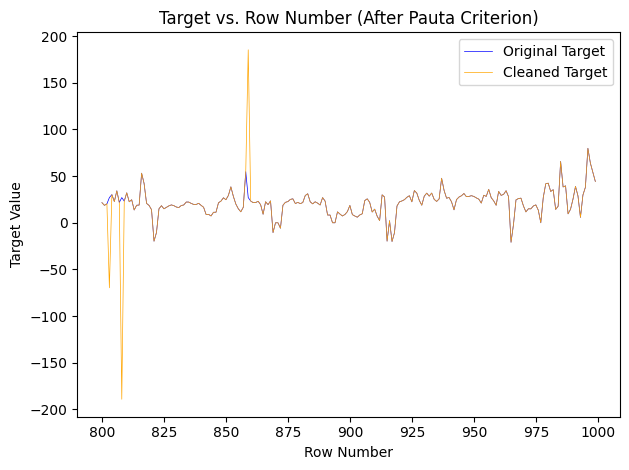

In [4]:
target_original = df["Target"].copy()

target_original = replace_outliers_pauta(target_original, method='median')

# Plot Before and After
plt.figure(figsize=(14, 1))


plt.tight_layout()
plt.show()
# Before Pauta Criterion
plt.subplot(1, 1, 1)
plt.plot(target_original[800:1000], label='Original Target', color='blue', linewidth=0.5)
plt.title("Target vs. Row Number (Before Pauta Criterion)")
plt.xlabel("Row Number")
plt.ylabel("Target Value")
plt.legend()

# After Pauta Criterion
plt.subplot(1, 1, 1)
plt.plot(df["Target"][800:1000], label='Cleaned Target', color='orange', linewidth=0.5)
plt.title("Target vs. Row Number (After Pauta Criterion)")
plt.xlabel("Row Number")
plt.ylabel("Target Value")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
y = target_original - min(target_original) +1

In [9]:
print(min(y))
print(max(y))

1.0
201.95


In [10]:
print(y)
y.isnull().sum()

0         85.15
1        123.65
2        127.43
3         81.89
4         81.94
          ...  
70123     95.50
70124     95.16
70125     95.16
70126     87.97
70127     92.20
Name: Target, Length: 70128, dtype: float64


0

In [11]:
y= np.log1p(y)
x = df.drop("Target", axis =1)

In [12]:
print(min(y))
print(max(y))

0.6931471805599453
5.312959643284906


In [13]:
a= np.log1p(1.71829)
a

1.0000030061374015

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
#x_train.head()

(56102, 75)
(56102,)
(14026, 75)
(14026,)


In [ ]:
epoch = 30
batch_size = 64
steps_per_epoch = len(x_train) // batch_size
cyclic_lr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-04,
                                                maximal_learning_rate=1e-02,
                                                scale_fn=lambda x: 1/(2**(x-1)),
                                                step_size=6 * steps_per_epoch)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)
def base_model_lstm():

    model = Sequential()
    model.add(LSTM(units = 128, return_sequences = True, activation="relu", input_shape = (75, 1),  recurrent_dropout=0.2, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model

lstm_model = base_model_lstm()
lstm_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
lstm_model.summary()

2024-11-26 17:33:27.602627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:65:00.0, compute capability: 7.5
2024-11-26 17:33:27.613510: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1101] failed to allocate 44.12MiB (46268416 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-11-26 17:33:27.613566: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1101] failed to allocate 39.71MiB (41641728 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-11-26 17:33:27.662259: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)
history = lstm_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs =epoch,
                   batch_size = batch_size, callbacks=[callback])

In [36]:
y_predict = lstm_model.predict(x_test)

#y_predict = y_predict.transpose()
y_predict = y_predict.flatten()
print(y_predict)
diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_predict})
print(diff)
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

439/439 [==============================] - 7s 14ms/step
[7.009518  7.010338  7.06822   ... 7.0174    7.0176883 7.0492196]
       Actual value  Predicted value
32189      7.002256         7.009518
41315      7.005880         7.010338
57975      7.071106         7.068220
14401      7.018026         7.026556
8550       7.011998         7.037103
...             ...              ...
10018      7.010501         7.017063
7757       7.007447         7.010921
32484      7.005571         7.017400
28814      7.009517         7.017688
54792      7.040440         7.049220

[14026 rows x 2 columns]


In [37]:
meanAbErr = metrics.mean_absolute_error(y_test, y_predict)
meanSqErr = metrics.mean_squared_error(y_test, y_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
mape= MAPE(y_test,y_predict)
#print('R squared: {:.2f}'.format(regr.score(x,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Absolute percentage Error:', mape)
#print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

Mean Absolute Error: 0.01202166772894837
Mean Absolute percentage Error: 0.1694343772856841
Root Mean Square Error: 0.03647839582504526


In [39]:
def MAP(Y_actual,Y_Predicted):
    mape = np.mean(np.abs(((1.71829**Y_actual) - (1.71829**Y_Predicted))/(1.71829**Y_actual))*100)
    return mape

In [40]:
meanAbErr = metrics.mean_absolute_error(y_test, y_predict)
meanSqErr = metrics.mean_squared_error(y_test, y_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
mape= MAP(y_test,y_predict)
#print('R squared: {:.2f}'.format(regr.score(x,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Absolute percentage Error:', mape)
#print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

Mean Absolute Error: 0.01202166772894837
Mean Absolute percentage Error: 0.643215525276926
Root Mean Square Error: 0.03647839582504526


In [55]:
a=np.expm1(y_test)
b=np.expm1(y_predict)

In [56]:
diff = pd.DataFrame({'Actual value': a, 'Predicted value': b})
print(diff)

       Actual value  Predicted value
32189       1098.11      1106.120850
41315       1102.10      1107.028809
57975       1176.45      1173.056519
14401       1115.58      1125.145020
8550        1108.87      1137.085449
...             ...              ...
10018       1107.21      1114.505737
7757        1103.83      1107.675171
32484       1101.76      1114.881348
28814       1106.12      1115.203247
54792       1140.89      1150.959473

[14026 rows x 2 columns]


In [57]:
a=a +min(df.Target)
b=b+ min(df.Target)

In [58]:
diff = pd.DataFrame({'Actual value': a, 'Predicted value': b})
print(diff)

       Actual value  Predicted value
32189         11.87        19.880859
41315         15.86        20.788818
57975         90.21        86.816528
14401         29.34        38.905029
8550          22.63        50.845459
...             ...              ...
10018         20.97        28.265747
7757          17.59        21.435181
32484         15.52        28.641357
28814         19.88        28.963257
54792         54.65        64.719482

[14026 rows x 2 columns]


In [65]:
def MAP(Y_actual, Y_Predicted):
    # Mask out Y_actual values where Y_actual = 0 or where Y_actual is between 2 and 3
    mask = (Y_actual != 0) & ~((Y_actual >= -60.715721725558176) & (Y_actual <= 141.48808169589813))
    
    # Apply the mask to both Y_actual and Y_Predicted
    Y_actual_filtered = Y_actual[mask]
    Y_Predicted_filtered = Y_Predicted[mask]
    
    # Calculate the MAPE on the filtered values
    mape = np.mean(np.abs((Y_actual_filtered - Y_Predicted_filtered) / Y_actual_filtered)) * 100
    return mape

In [66]:
meanAbErr = metrics.mean_absolute_error(y_test, y_predict)
meanSqErr = metrics.mean_squared_error(y_test, y_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
mape= MAP(a,b)
#print('R squared: {:.2f}'.format(regr.score(x,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Absolute percentage Error:', mape)
#print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

Mean Absolute Error: 0.01202166772894837
Mean Absolute percentage Error: 45.64458684851612
Root Mean Square Error: 0.03647839582504526


67.40126780715211

In [63]:
df['Target'].mean()+ 1.5 *df['Target'].std()

141.48808169589813

In [64]:
df['Target'].mean()- 1.5 *df['Target'].std()

-60.715721725558176